# What will be the price per ton of aluminum on 1 June 2022?
https://www.infer-pub.com/questions/1029-what-will-the-price-per-ton-of-aluminum-be-on-1-june-2022

I will use the past price of aluminum to build an ARIMA model to forecast the future price. I'll be consulting https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
from scipy.stats import norm 
import exchange_calendars as xcals

<AxesSubplot:>

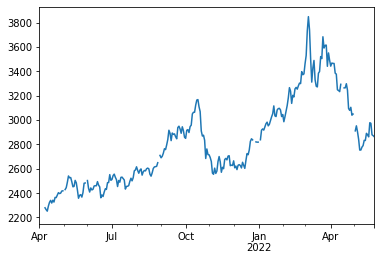

In [2]:
price_history = pd.read_csv('data/Aluminum.csv')
business_day = xcals.get_calendar('XLON').day
index = pd.PeriodIndex(price_history['Date'], freq=business_day)
price_history = price_history.set_index(index).sort_index()
price_history = price_history.reindex(pd.period_range(price_history.index[0], price_history.index[-1], freq=business_day))
price_history = price_history['Close'].sort_index()
price_history.plot()

### 1. Stationarize the series

https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(timeseries.interpolate(), autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(timeseries.interpolate(), regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [4]:
adf_test(price_history)

Results of Dickey-Fuller Test:
Test Statistic                  -1.876411
p-value                          0.343238
#Lags Used                       1.000000
Number of Observations Used    299.000000
Critical Value (1%)             -3.452411
Critical Value (5%)             -2.871255
Critical Value (10%)            -2.571947
dtype: float64


In [5]:
kpss_test(price_history)

Results of KPSS Test:
Test Statistic            2.047628
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both tests indicate that the series is non-stationary

<AxesSubplot:>

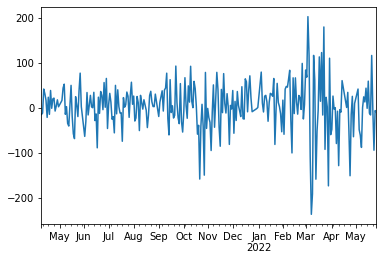

In [6]:
differenced = price_history.diff().dropna()
differenced.plot()

In [7]:
adf_test(differenced)

Results of Dickey-Fuller Test:
Test Statistic                -1.534824e+01
p-value                        3.750521e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.780000e+02
Critical Value (1%)           -3.454094e+00
Critical Value (5%)           -2.871993e+00
Critical Value (10%)          -2.572340e+00
dtype: float64


In [8]:
kpss_test(differenced)

Results of KPSS Test:
Test Statistic           0.081942
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both tests now indicate the series is stationary!

### 2. Study autocorrelations to determine if lags of the series and/or lags of the forecast errors should be included in the model
https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html?highlight=autocorrelation

/home/jonah/.virtualenvs/infer-pub/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


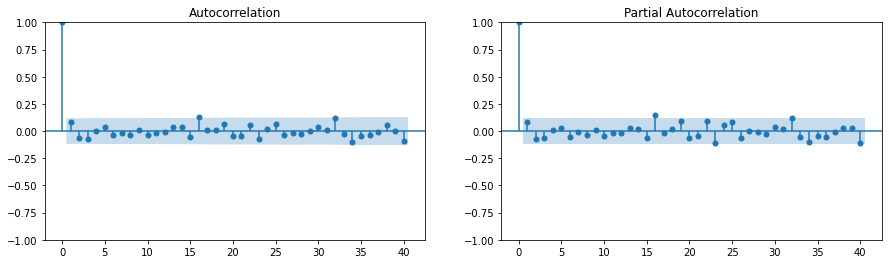

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(differenced, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(differenced, lags=40, ax=axes[1])

I think I will use an AR(1) model

In [10]:
model = sm.tsa.ARIMA(price_history, order=(1, 0, 0))
results = model.fit()
prediction_day = '2022-06-01'
forecast_results = results.get_forecast(prediction_day)
summary = forecast_results.summary_frame()
summary

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-05-27,2862.038618,53.496581,2757.187246,2966.889991
2022-05-30,2861.503015,75.252894,2714.010053,3008.995978
2022-05-31,2860.973129,91.676781,2681.289941,3040.656317
2022-06-01,2860.448900,105.299806,2654.065071,3066.832728


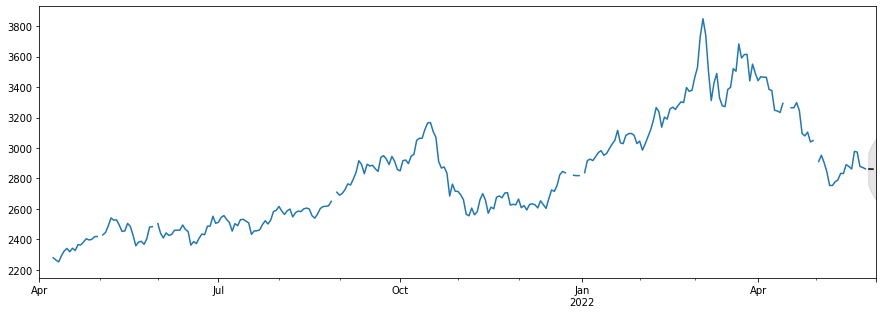

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
price_history.plot(ax=ax)
fcast = results.get_forecast('2022-06-01').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [12]:

mean = summary.loc[prediction_day]['mean']
se = summary.loc[prediction_day]['mean_se']
dist = norm(mean, se)
forecast = {
    "Less than $3000": dist.cdf(3000),
    "More than or equal to $3000 but less than $3500": dist.cdf(3500) - dist.cdf(3000),
    "More than or equal to $3500 but less than $4000": dist.cdf(4000) - dist.cdf(3500),
    "More than or equal to $4000": 1 - dist.cdf(4000)
}
{k: f'{round(100*v)}%' for k, v in forecast.items()}

{'Less than $3000': '91%',
 'More than or equal to $3000 but less than $3500': '9%',
 'More than or equal to $3500 but less than $4000': '0%',
 'More than or equal to $4000': '0%'}